# Quenching Fraction Label
----

<h4> Description </h4>
The best ML code for the quenching label is also ANN. I got accuracies of 98% and 94% for COSMOS and SDSS+GALEX+WISE respectively. Regarding the model, the color (g-r) has the most power of constraining the quenched galaxies. The feature selection, the addition of the red-sequence offset provides a marginal increase on the accuracy. For simplicity, I'll just use stellar mass, colors and redshift as a feature.

In [1]:
import numpy as np
import astropy.io.ascii as at
import scipy.stats as st
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import os

sns.set_style("whitegrid")
sns.set_context('talk',rc={"lines.linewidth": 2.5})


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
%matplotlib_inline

UsageError: Line magic function `%matplotlib_inline` not found.


## Load Cosmos Sample

In [699]:
# path = '/data/des61.a/data/johnny/COSMOS/fnal2022/'
path = '/Users/jesteves/Downloads/'
fname = path+'desCosmosML_sample.fits'
joined = Table(getdata(fname))

In [713]:
mask = (joined['SFR']<=4.)&(joined['SFR']>=-4.5)&(joined['smass']>=8.)
ssfr = np.array(joined['sSFR'])[mask]
sfr = np.array(joined['SFR'])[mask]
smass= np.array(joined['smass'])[mask]

Text(0.5, 1.0, 'Red and Blue')

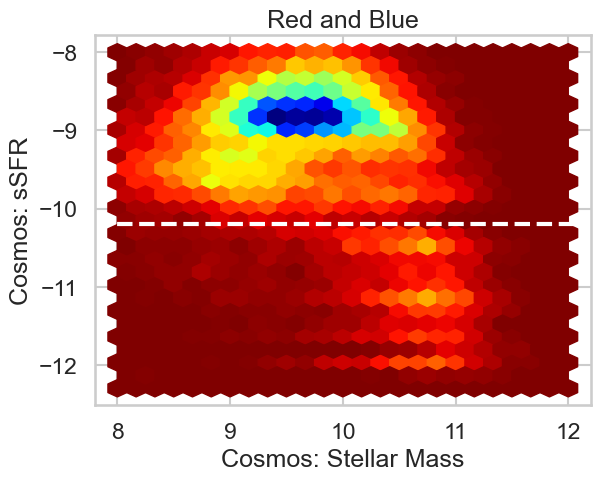

In [714]:
plt.hexbin(smass,ssfr,extent=[8,12,-12.3,-8],gridsize=24,cmap='jet_r')
plt.axhline(-10.2,color='w',ls='--',lw=3)
plt.xlabel('Cosmos: Stellar Mass')
plt.ylabel('Cosmos: sSFR')
plt.title('Red and Blue')

Text(0.5, 1.0, 'Red and Blue')

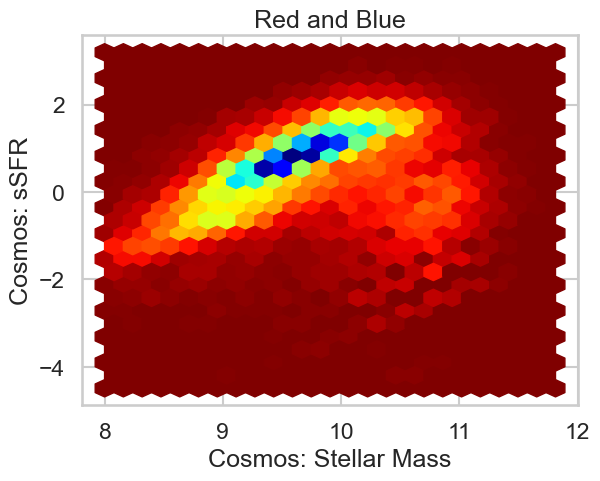

In [715]:
plt.hexbin(smass,sfr,gridsize=24,cmap='jet_r')
# plt.axhline(-10.2,color='w',ls='--',lw=3)
plt.xlabel('Cosmos: Stellar Mass')
plt.ylabel('Cosmos: sSFR')
plt.title('Red and Blue')

In [716]:
from sklearn.mixture import GaussianMixture
def define_qf_label(sfr,smass):
    mask = (sfr<=4.)&(sfr>=-4.5)&(smass>=8.)
    ssfr = np.log10(10**sfr/10**smass)
    X = np.c_[sfr[mask],smass[mask]]
    Xall = np.c_[sfr,smass]
    gmm = GaussianMixture(n_components=2).fit(X)
    y_prob_all = gmm.predict_proba(Xall)
    qf_all = np.where((y_prob_all[:,0]>=0.5)&(ssfr<=-9),1,0)
    return qf_all, y_prob_all[:,0]

In [717]:
qf_all, y_prob_all = define_qf_label(joined['SFR'],joined['smass'])
# qf_all = y_prob_all
qf_all = np.where(joined['sSFR']<=-10.2,1,0)

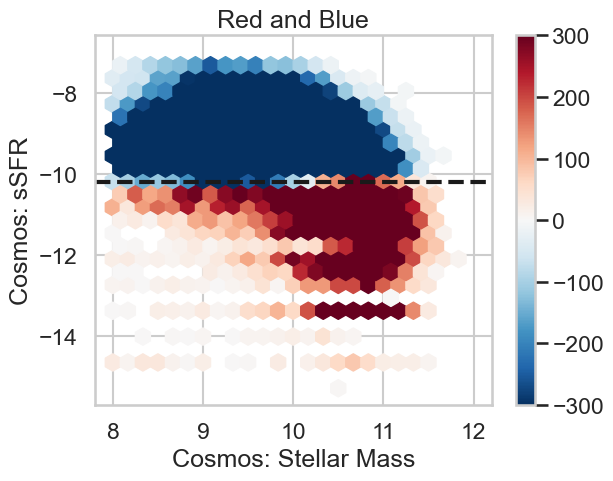

In [718]:
qf_all_c = np.where(qf_all==0,-1,qf_all)
plt.hexbin(joined['smass'],joined['sSFR'],extent=[8,12,-15.3,-7],C=qf_all_c,gridsize=24,cmap='RdBu_r',reduce_C_function=np.sum,vmin=-300.,vmax=300)
plt.axhline(-10.2,color='k',ls='--',lw=3)
plt.xlabel('Cosmos: Stellar Mass')
plt.ylabel('Cosmos: sSFR')
plt.title('Red and Blue')
plt.colorbar()
plt.show()

## Prepare Input Variables

In [719]:
# load rs
npzfile = np.load('../data/rs_slope_redMaPPer_y3.npz')
zmed = npzfile['z']
parameters = npzfile['coefs']

In [720]:
def get_rs_offset(z,mi,ix):
    slope = parameters[:,ix,0]
    mean_color = parameters[:,ix,1]
    return np.interp(z,zmed,slope)*(mi+20.) + np.interp(z, zmed, mean_color)

In [721]:
def transform_to_1d(x,y):
    ynew = y[:,0]
    x[:,4:4+3] = np.c_[[x[:,4+ix]-get_rs_offset(x[:,-1],y[:,1],ix) for ix in range(3)]].T
    xnew = np.vstack([x.T,y[:,1]]).T
    return xnew, ynew

In [722]:
path = '../data/'
x_train = np.load(path+'qf_x_train.npy')
y_train = np.load(path+'qf_y_train.npy')

x_test = np.load(path+'qf_x_test.npy')
y_test = np.load(path+'qf_y_test.npy')

zcut = x_train[:,-1]<=1.2
x_train = x_train[zcut,:]
y_train = y_train[zcut,:]

zcut2 = x_test[:,-1]<=1.2
x_test = x_test[zcut2,:]
y_test = y_test[zcut2,:]
# y_train_err = np.array(joined['smass_err'][joined['Train']])

In [723]:
x_test1d, y_test1d = transform_to_1d(x_test,y_test)
x_train1d, y_train1d = transform_to_1d(x_train,y_train)

In [725]:
qy_test = np.array(qf_all[~joined['Train']])[zcut2]
qy_train = np.array(qf_all[joined['Train']])[zcut]

x_train_small = x_train1d[:,4:]
x_test_small = x_test1d[:,4:]

In [726]:
# ix=1
# plt.scatter(x_test1d[:,-2],x_test1d[:,4+ix],s=20,alpha=0.3)
# plt.xlim(0.,1.2)
# plt.ylim(-1.4,1.0)
# plt.xlabel('redshift')

# print(np.std(x_test1d[:,4+ix]))

## Cross Validation Sample

In [727]:
def convert_mag_to_fluxes(mag,f_o=10**12):
    return f_o*10.**(-mag/2.5)

def convert_mag_to_lupmag(mags, a=2.5*np.log10(np.exp(1)), f_o=10**12):
    # define quantities
    m_o = 2.5*np.log10(f_o)
    #mags = np.c_[g,r,i,z]
    fluxes = convert_mag_to_fluxes(mags)

    # sigma = 10**np.std(np.log10(fluxes),axis=0)
    sigma = np.array([28.79631884352346, 39.89162179800252, 67.37310780328083, 118.70759986796102]) # g,r,i,z
    b = np.sqrt(a)*sigma

    # define g,r,i,z fluxes as a numpy array
    # luptitudes and errors
    lups = (m_o - 2.5*np.log10(b)) - a*np.arcsinh(fluxes/(2*b))
    lup_errors = np.sqrt(((a**2) * (sigma**2)) / (4*(b**2) + (fluxes**2)))

    return lups, lup_errors

def get_input_galpro(mags, redshift, a=2.5*np.log10(np.exp(1)), f_o=10**12, normalize=False):
    # lupMags
    lups, lup_errors = convert_mag_to_lupmag(mags, a=a, f_o=f_o)
    g_r = lups[:, 0] - lups[:, 1]
    r_i = lups[:, 1] - lups[:, 2]
    i_z = lups[:, 2] - lups[:, 3]
    
    # colour errors
    g_r_err = ((lup_errors[:, 0]**2) + (lup_errors[:, 1]**2))**0.5
    r_i_err = ((lup_errors[:, 1]**2) + (lup_errors[:, 2]**2))**0.5
    i_z_err = ((lup_errors[:, 2]**2) + (lup_errors[:, 3]**2))**0.5
    
    # abs mag
    distMod = cosmo.distmod(redshift).value
    absMags = lups-distMod[:,np.newaxis]

    # combining everything
    x_target = np.c_[lups, g_r, r_i, i_z, lup_errors, g_r_err, r_i_err, i_z_err, redshift]
    return x_target

In [728]:
from astropy.cosmology import WMAP9 as cosmo
## load target data
fname = '../data/des_sdssGalexWISE_matched.csv'
data = at.read(fname)

mags = np.c_[[data['sof_cm_mag_corrected_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mags_err = np.c_[[data['sof_cm_mag_err_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mask= data['sdss_mass']>0.
ztrue= data['sdss_z']
smass= data['sdss_mass'][mask]
sfr = data['sdss_sfr'][mask]

x_target = get_input_galpro(mags[mask],ztrue[mask])

distMod = cosmo.distmod(ztrue[mask]).value
absMags = x_target[:,:4]-distMod[:,np.newaxis]
x_target1d = np.c_[x_target,absMags[:,2]]
x_target1d[:,4:4+3] = np.c_[[x_target1d[:,4+ix]-get_rs_offset(ztrue[mask],absMags[:,2],ix) for ix in range(3)]].T

y_target = np.array(smass)
x_target_small = x_target1d[:,4:]

In [730]:
# ix=1
# plt.scatter(x_target1d[:,-2],x_target1d[:,4+ix],s=20,alpha=0.3)
# plt.xlim(0.,0.3)
# plt.ylim(-0.5,0.5)
# plt.xlabel('redshift')

# print(np.std(x_test1d[:,4+ix]))

In [678]:
ssfr = ssfr = np.log10(10**sfr/10**smass)
qf_all, y_prob_all = define_qf_label(sfr, smass)

# FLIP THINGS
# qf_all, y_prob_all = np.where(qf_all==1,0,1), 1-y_prob_all
qf_all = np.where(ssfr<=-11.,1,0)
qy_target = qf_all


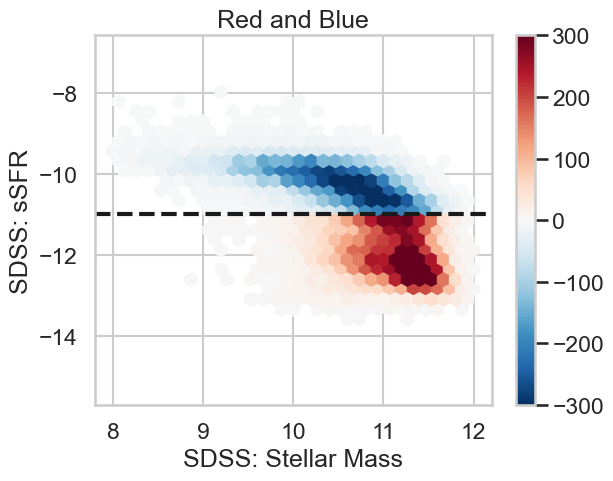

In [679]:
qf_all_c = np.where(qf_all==0,-1,qf_all)
plt.hexbin(smass,ssfr,extent=[8,12,-15.3,-7],C=qf_all_c,gridsize=30,cmap='RdBu_r',reduce_C_function=np.sum,vmin=-300.,vmax=300)
plt.axhline(-11.0,color='k',ls='--',lw=3)
plt.xlabel('SDSS: Stellar Mass')
plt.ylabel('SDSS: sSFR')
plt.title('Red and Blue')
plt.colorbar()

In [731]:
## Much simple model
# train
colors = x_train[:,4:(4+3)]
Mz = y_train1d#x_train1d[:,-1]
mz = x_train[:,3]
mz_err = x_train[:,4+3+3]
z = x_train1d[:,-2]
x_train_2 = np.c_[Mz, colors, mz_err, z]

# test
colors = x_test[:,4:(4+3)]
# Mz = x_test1d[:,-1]
Mz = y_test1d
mz = x_test[:,3]
mz_err = x_test[:,4+3+3]
z = x_test1d[:,-2]
x_test_2 = np.c_[Mz, colors, mz_err, z]

# target
x_target_2 = np.c_[y_target, x_target1d[:,4:(4+3)], x_target1d[:,4+3+3], x_target1d[:,-2]]

In [732]:
# ix=0
# plt.scatter(x_target_2[:,-1],x_target_2[:,1+ix],s=20,alpha=0.3)
# plt.xlim(0.,0.3)
# plt.ylim(-0.5,0.5)
# plt.xlabel('redshift')

# print(np.std(x_test1d[:,4+ix]))

## Training with ML Architectures

In [733]:
# idx = np.random.randint(len(y_train1d), size=10000)
idx = np.arange(len(y_train1d))
x = x_train_2[idx,:]
y = qy_train[idx]
x_pred = x_target_2

In [734]:
# from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Create classifiers
lr = LogisticRegression(n_jobs=-1)
gnb = GaussianNB()
ann = MLPClassifier()
gbc = GradientBoostingClassifier()

clf_list = [
    (ann, "ANN"),
    (gbc, "Gradient Boost"),
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
]

In [736]:
import time
def header(name):
    print(5*'-----')
    print('Machine Learning Training: %s'%name)

def fit(self,x,y):
    start_time = time.time()
    self.fit(x,y)
    self.elapsed_time = (time.time()-start_time)/60.
    print('Elapsed time: %.2f min'%self.elapsed_time)
    
for i, (clf, name) in enumerate(clf_list):
    header(name)
    fit(clf,x,y)
    print('')

-------------------------
Machine Learning Training: ANN


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Elapsed time: 3.20 min

-------------------------
Machine Learning Training: Gradient Boost
Elapsed time: 1.32 min

-------------------------
Machine Learning Training: Logistic
Elapsed time: 0.06 min

-------------------------
Machine Learning Training: Naive Bayes
Elapsed time: 0.00 min



In [737]:
from sklearn.metrics import accuracy_score

def show_score(self,x_pred,y):
    y_pred = self.predict(x)
    self.myscore = accuracy_score(y, y_pred)
    print('Accuracy Score: %.3f'%self.myscore)

for i, (clf, name) in enumerate(clf_list):
    header(name)
    show_score(clf,x_pred,y)
    print('')

-------------------------
Machine Learning Training: ANN
Accuracy Score: 0.938

-------------------------
Machine Learning Training: Gradient Boost
Accuracy Score: 0.934

-------------------------
Machine Learning Training: Logistic
Accuracy Score: 0.921

-------------------------
Machine Learning Training: Naive Bayes
Accuracy Score: 0.911



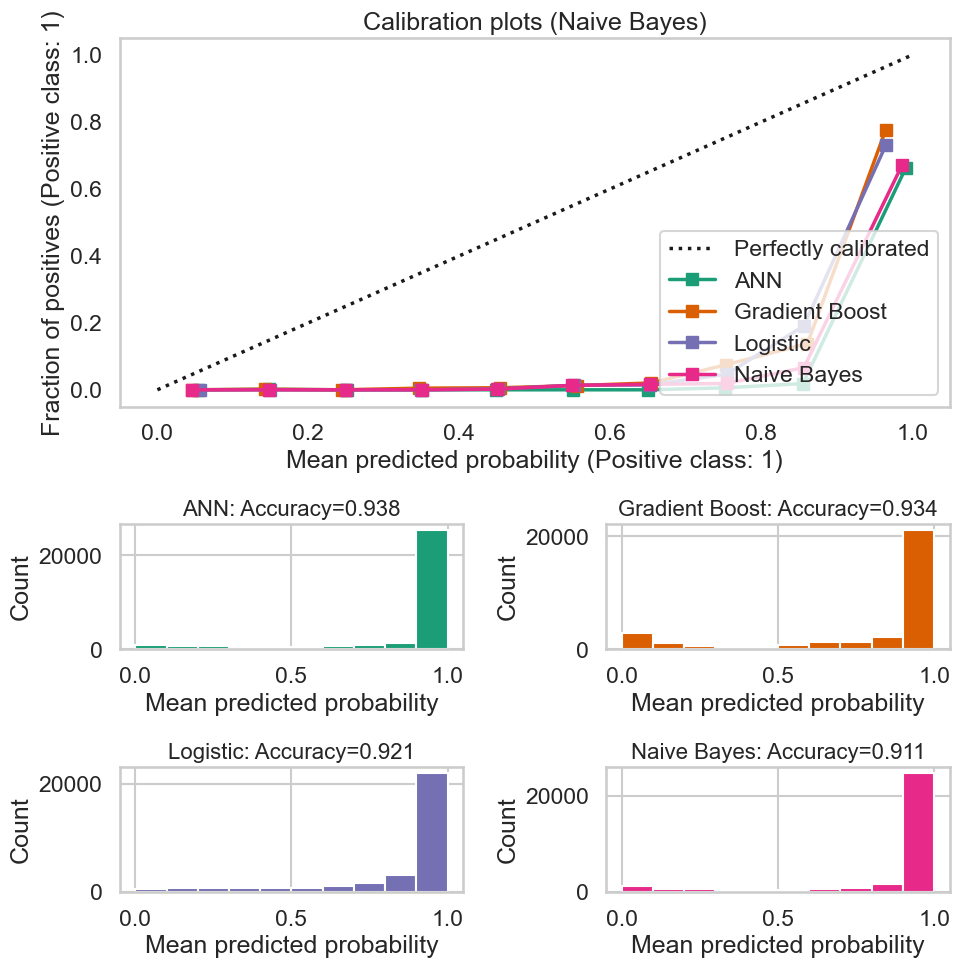

In [738]:
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf,
        x_pred,
        qy_target,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (clf, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(xlabel="Mean predicted probability", ylabel="Count")
    ax.set_title(name+': Accuracy=%.3f'%(clf.myscore),fontsize=16)

plt.tight_layout()
plt.show()

In [739]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

def perform_calibration(clf,X_train,y_train,X_test,y_test):
    prob_pos_clf = clf.predict_proba(X_test)[:, 1]

    # With isotonic calibration
    clf_isotonic = CalibratedClassifierCV(clf, cv='prefit', method="isotonic")
    clf_isotonic.fit(X_train, y_train)
    prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

    # With sigmoid calibration
    clf_sigmoid = CalibratedClassifierCV(clf, cv='prefit', method="sigmoid")
    clf_sigmoid.fit(X_train, y_train)
    prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

    print("Brier score losses: (the smaller the better)")

    clf_score = brier_score_loss(y_test, prob_pos_clf)
    print("No calibration: %1.3f" % clf_score)

    clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic)
    print("With isotonic calibration: %1.3f" % clf_isotonic_score)

    clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid)
    print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

In [740]:
# for i, (clf, name) in enumerate(clf_list):
#     header(name)
#     perform_calibration(clf, x_pred, qy_target, x_pred, qy_target)
#     print('')

In [741]:
def perform_isotonic_calibration(clf,X_train,y_train,X_test,y_test):
    print('Perform Isotonic Calibration')
    prob_pos_clf = clf.predict_proba(X_test)[:, 1]
    
    # With isotonic calibration
    clf_isotonic = CalibratedClassifierCV(clf, cv='prefit', method="isotonic")
    clf_isotonic.fit(X_train, y_train)
    prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

    print("Brier score losses: (the smaller the better)")

    clf_score = brier_score_loss(y_test, prob_pos_clf)
    print("No calibration: %1.3f" % clf_score)

    clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic)
    print("With isotonic calibration: %1.3f" % clf_isotonic_score)
    return clf_isotonic

clf_list_cal = []
for i, (clf, name) in enumerate(clf_list):
    header(name)
    clf_cal = perform_isotonic_calibration(clf, x_test_2, qy_test, x_test_2, qy_test)
    show_score(clf_cal,x_pred,y)
    clf_list_cal.append([clf_cal,name])
    print('')

-------------------------
Machine Learning Training: ANN
Perform Isotonic Calibration
Brier score losses: (the smaller the better)
No calibration: 0.045
With isotonic calibration: 0.044
Accuracy Score: 0.937

-------------------------
Machine Learning Training: Gradient Boost
Perform Isotonic Calibration
Brier score losses: (the smaller the better)
No calibration: 0.051
With isotonic calibration: 0.049
Accuracy Score: 0.934

-------------------------
Machine Learning Training: Logistic
Perform Isotonic Calibration
Brier score losses: (the smaller the better)
No calibration: 0.057
With isotonic calibration: 0.056
Accuracy Score: 0.922

-------------------------
Machine Learning Training: Naive Bayes
Perform Isotonic Calibration
Brier score losses: (the smaller the better)
No calibration: 0.070
With isotonic calibration: 0.061
Accuracy Score: 0.918



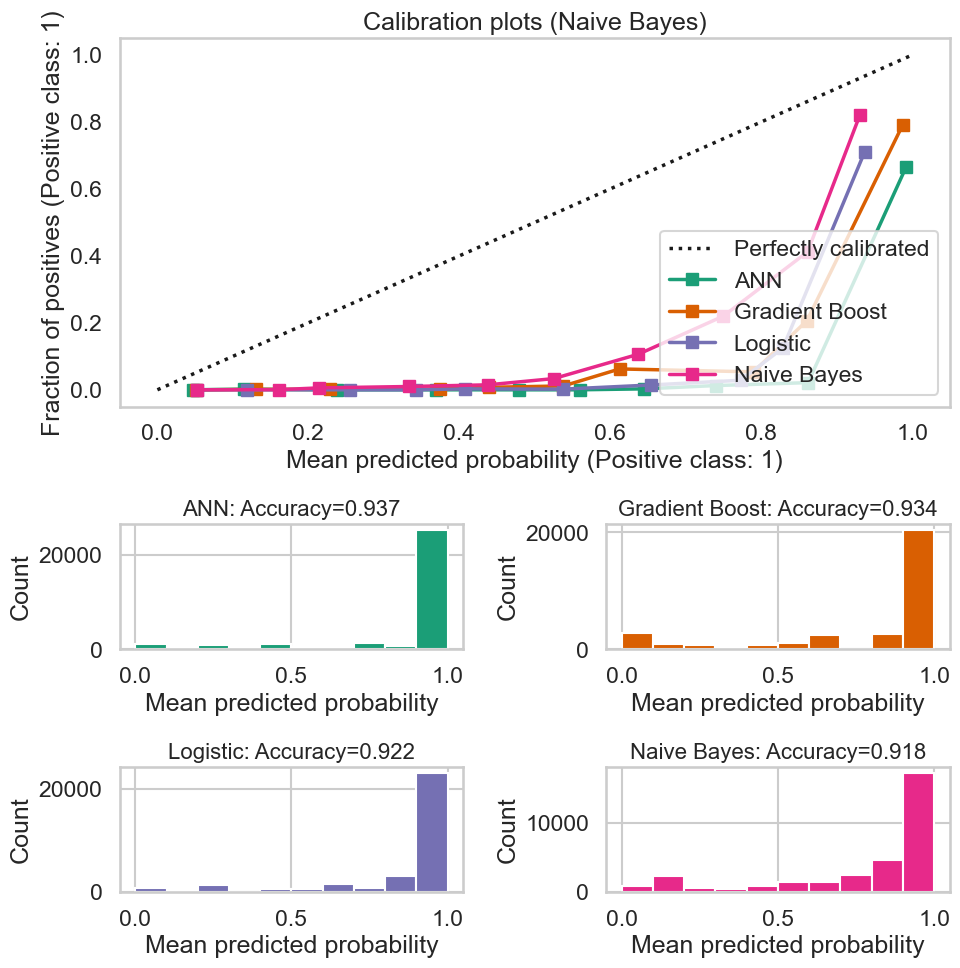

In [742]:
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list_cal):
    display = CalibrationDisplay.from_estimator(
        clf,
        x_pred,
        qy_target,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (clf, name) in enumerate(clf_list_cal):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(xlabel="Mean predicted probability", ylabel="Count")
    ax.set_title(name+': Accuracy=%.3f'%(clf.myscore),fontsize=16)

plt.tight_layout()
plt.show()

## Feature Importance

Elapsed time to compute the importances: 0.048 seconds


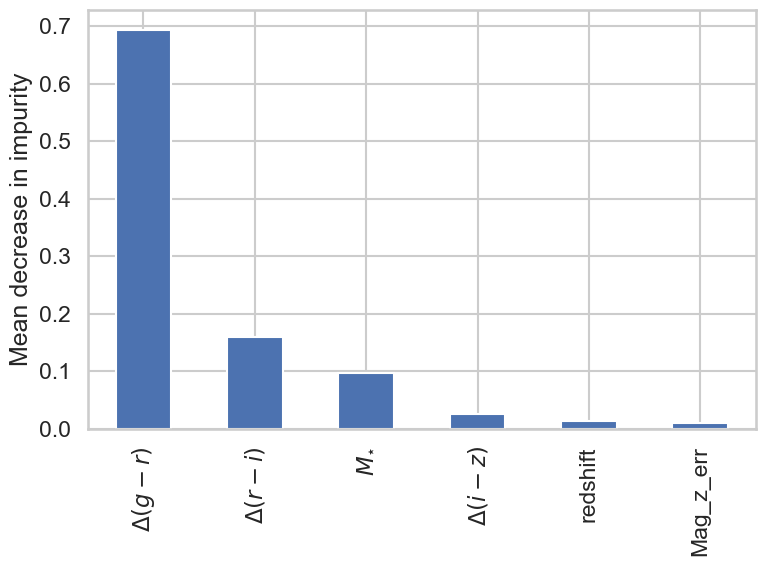

In [743]:
import time
import numpy as np

est = clf_list[1][0]
start_time = time.time()
importances = est.feature_importances_
std = np.std([est.feature_importances_ for tree in est.estimators_], axis=0)
elapsed_time = time.time() - start_time

print("Elapsed time to compute the importances: {elapsed_time:.3f} seconds".format(elapsed_time=elapsed_time))

feature_names = [r'$M_{\star}$']
feature_names+= [r'$\Delta (%s - %s)$'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['Mag_%s_err'%bpF for bpF in ['z']]
# feature_names+= ['Err(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['redshift']


feature_names

ix = np.argsort(-1*importances)
forest_importances = pd.Series(importances[ix], index=np.array(feature_names)[ix])

fig, ax = plt.subplots(figsize=(8,6))
forest_importances.plot.bar(yerr=std[ix], ax=ax)
# ax.set_title("Cosmos with Mag-DM and RedSeq Offset")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
# fig.savefig('feature_importance_mag_dm_rs.png',dpi=100,transparent=False,facecolor='w')

In [744]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown


ANN - P_threshold: 0.41
Gradient Boost - P_threshold: 0.38
Logistic - P_threshold: 0.45
Naive Bayes - P_threshold: 0.62


Text(0.5, 1.0, 'Cosmos Test Sample')

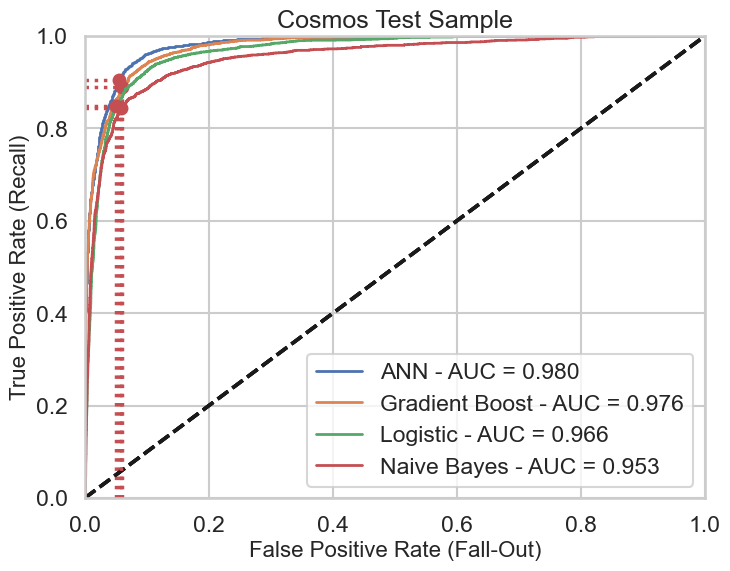

In [745]:
plt.figure(figsize=(8, 6))                                    # Not shown

xt = x_target_2
yt = qy_target

xt = x_test_2
yt = qy_test
for i, (clf, name) in enumerate(clf_list):
    y_pred = clf.predict_proba(xt)

    auc = roc_auc_score(yt, y_pred[:,1])
    fpr, tpr, thresholds = roc_curve(yt, y_pred[:,1])
    precisions, recalls, thresholds = precision_recall_curve(yt, y_pred[:,1])
    
    print('%s - P_threshold: %.2f'%(name,thresholds[np.argmax(precisions*recalls)]))
    recall_90_precision = recalls[np.argmax(precisions*recalls)]
    threshold_90_precision = thresholds[np.argmax(precisions*recalls)]


    plot_roc_curve(fpr, tpr, label='%s - AUC = %.3f'%(name,auc))
    fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
    plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
    # save_fig("roc_curve_plot")                                    # Not shown
    plt.legend()
plt.title('Cosmos Test Sample')

ANN - P_threshold: 1.00
Gradient Boost - P_threshold: 0.92
Logistic - P_threshold: 0.93
Naive Bayes - P_threshold: 0.98


Text(0.5, 1.0, 'SDSS+GALEX+WISE')

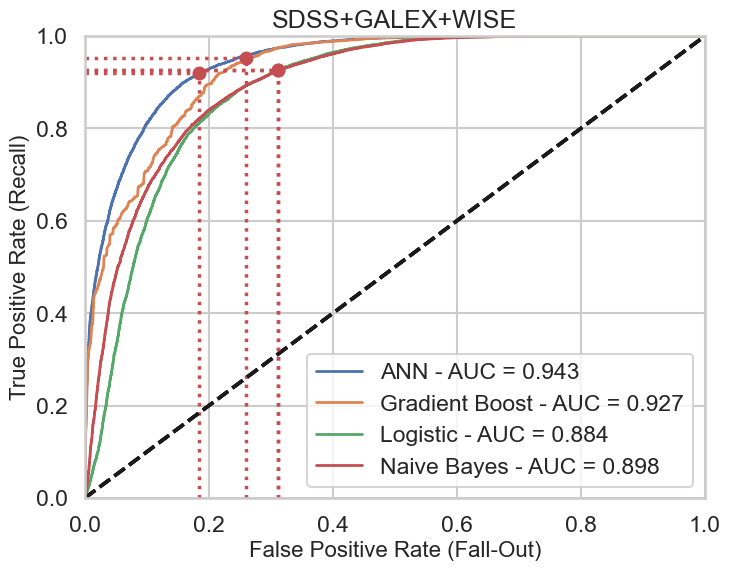

In [746]:
plt.figure(figsize=(8, 6))                                    # Not shown

xt = x_target_2
yt = qy_target

# xt = x_test_2
# yt = qy_test
for i, (clf, name) in enumerate(clf_list):
    y_pred = clf.predict_proba(xt)

    auc = roc_auc_score(yt, y_pred[:,1])
    fpr, tpr, thresholds = roc_curve(yt, y_pred[:,1])
    precisions, recalls, thresholds = precision_recall_curve(yt, y_pred[:,1])
    
    print('%s - P_threshold: %.2f'%(name,thresholds[np.argmax(precisions*recalls)]))
    recall_90_precision = recalls[np.argmax(precisions*recalls)]
    threshold_90_precision = thresholds[np.argmax(precisions*recalls)]


    plot_roc_curve(fpr, tpr, label='%s - AUC = %.3f'%(name,auc))
    fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
    plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
    # save_fig("roc_curve_plot")                                    # Not shown
    plt.legend()
plt.title('SDSS+GALEX+WISE')

## Looking at the data

In [747]:
def get_lims(x):
    q1,q2,q3 = np.percentile(x, [16,50,84])
    qlow, qhig = q2-5*(q3-q1)/2.,q2+5*(q3-q1)/2.
    return qlow, qhig

In [748]:
color_labels = [r'$(%s - %s)$'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]

In [756]:
clf = clf_list[0][0]
# xt = x_target_2
# yt = qy_target

xt = x_test_2
yt = qy_test

# y_pred = clf.predict(xt)
y_pred = clf.predict_proba(xt)[:,1]

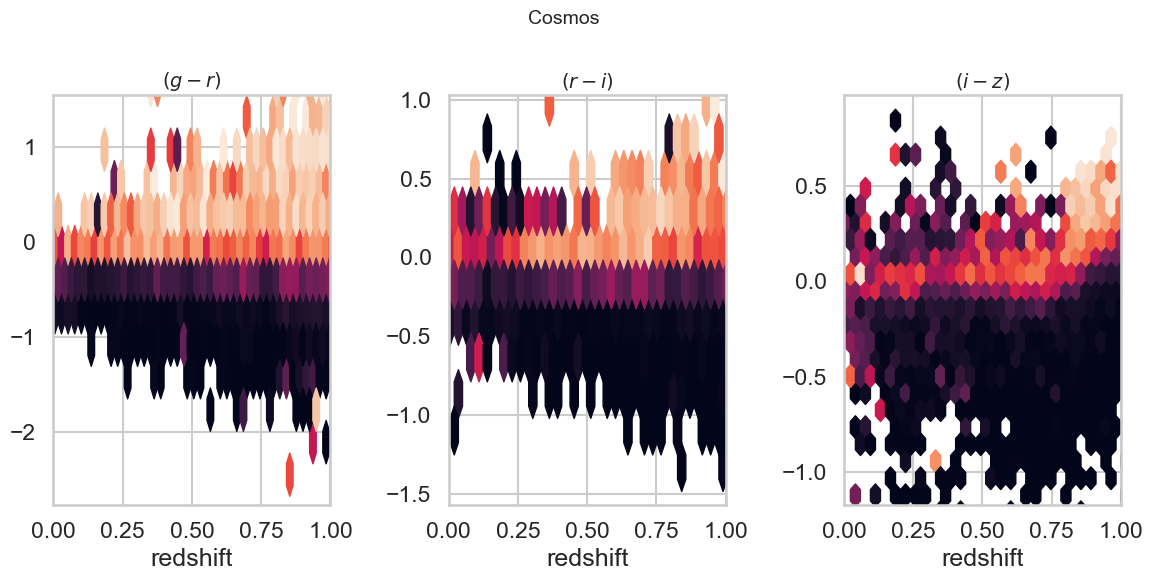

In [759]:
fig, axs = plt.subplots(1,3, figsize=(12,6.))

# ix = np.argsort()
for ix in range(3):
    im = axs[ix].hexbin(xt[:,-1],xt[:,1+ix],C=y_pred,gridsize=int(50/(1+0.25*ix)))
    #axs[ix].set_xlim(0.,np.percentile(xt[:,-1],99)+0.02)
    axs[ix].set_xlim(0., 1.)
    # plt.ylim(-0.5,0.5)
    axs[ix].set_xlabel('redshift')
    axs[ix].set_ylim(get_lims(xt[:,1+ix]))
    axs[ix].set_title(color_labels[ix],fontsize=14)
fig.suptitle('Cosmos',fontsize=14)    
fig.tight_layout()

In [751]:
clf = clf_list[0][0]
xt = x_target_2
yt = qy_target

# xt = x_test_2
# yt = qy_test

# y_pred = clf.predict(xt)
y_pred = clf.predict_proba(xt)[:,1]

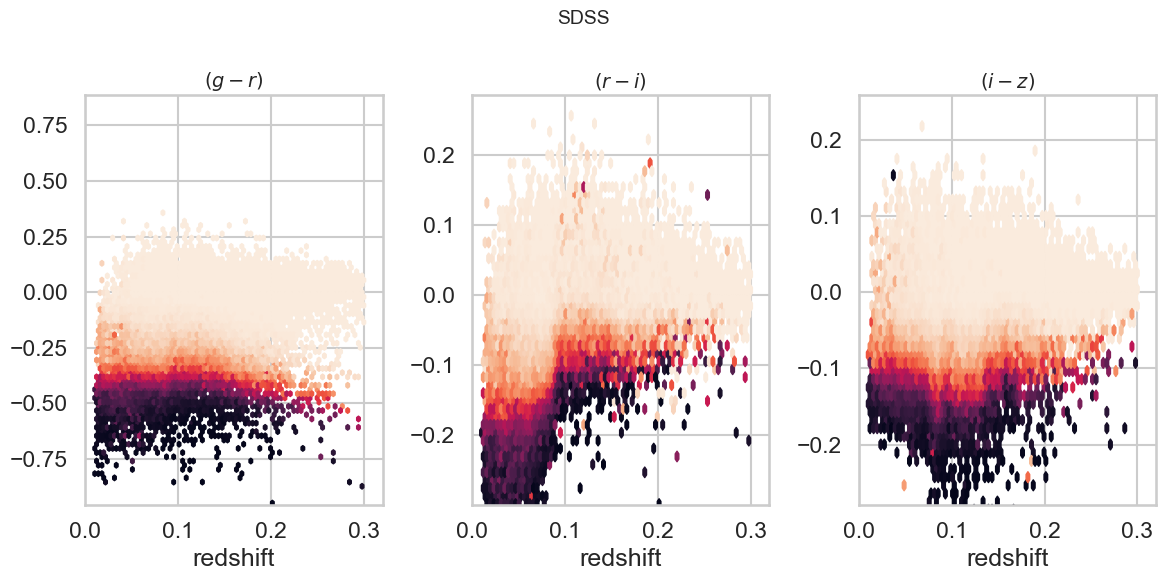

In [754]:
fig, axs = plt.subplots(1,3, figsize=(12,6.))

# ix = np.argsort()
for ix in range(3):
    im = axs[ix].hexbin(xt[:,-1],xt[:,1+ix],C=y_pred,gridsize=int(75))
    #axs[ix].set_xlim(0.,np.percentile(xt[:,-1],99)+0.02)
    axs[ix].set_xlim(0., 0.32)
    axs[ix].set_ylim(-0.5,2.)
    axs[ix].set_xlabel('redshift')
    axs[ix].set_ylim(get_lims(xt[:,1+ix]))
    axs[ix].set_title(color_labels[ix],fontsize=14)
fig.suptitle('SDSS',fontsize=14)    
fig.tight_layout()